In [1]:
%load_ext autoreload

In [2]:

%autoreload 2
from UgandaUber.Estimation.modules.data_creation import UberDatasetCreator
from UgandaUber.Estimation.modules.regression import uber_regression, get_reg_effect
from UgandaUber.Estimation.modules.mle import UberMLE, SimplifiedUberMLE, get_mle_betas
from UgandaUber.Estimation.modules.visualization import Visualizer
import os
os.environ['OMP_NUM_THREADS'] = '8'
import numpy as np
import statsmodels.formula.api as smf
# import plotly.express as px
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual, fixed
import ast
from scipy.special import logit, softmax


In [11]:

# %% [markdown]
# ## Regression Approach

# %%
# Load in data from Uber Dataset Creator

beta0 = [1, 2,3]
beta1 = [-1, -2, -4]


u = UberDatasetCreator(seed=1, regimes=3, drivers= 275)
df, wm = u.construct(y_sd = [1,1,1],
                drought_mean = [0,0,0],
                drought_cov = [[1,.8,.8], [.8,1,.8],[.8,.8,1]],
                beta0 = beta0,
                beta1 = beta1,
                y_name = 'y',
                weight = .8,
                # reg_ready=True
                )

classifier_cols = df.columns[df.columns.str.contains("misclass_regime_")].tolist()

drought_cols = df.columns[df.columns.str.contains("drought_")].tolist()   

mod = uber_regression(df, 'y', classifier_cols=classifier_cols, drought_cols=drought_cols)

p_mat_start = logit(np.diag(wm))

res = mod.fit()

print(res.summary())



OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     386.7
Date:                Fri, 04 Sep 2020   Prob (F-statistic):          1.59e-314
Time:                        16:47:37   Log-Likelihood:                -5011.7
No. Observations:                2750   AIC:                         1.004e+04
Df Residuals:                    2744   BIC:                         1.007e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
misclass_regime_0               1.5331      0.

In [12]:
a,b,c =get_reg_effect(res)
c

array([ 1.53309359,  1.7945317 ,  2.64267909, -0.99749697, -1.59868482,
       -3.3118997 ])

In [13]:
# %%
us = SimplifiedUberMLE(data = df, 
            endog_col = 'y', 
            classifier_cols = classifier_cols,
            drought_cols=drought_cols)  

_, _, start_params = get_reg_effect(res)

start_params = np.append(start_params, np.full((1,u.regimes), 1)) # sigma
start_params = np.append(start_params, np.full(shape = (1,u.regimes-1), fill_value = logit(1/u.regimes))) # l_vec
start_params = np.append(start_params, p_mat_start)

res_smle_s = us.fit(start_params=start_params, method = 'bfgs')

print(res_smle_s.summary())

# %%
us = UberMLE(data = df, 
            endog_col = 'y', 
            classifier_cols = classifier_cols,
            drought_cols=drought_cols)  

_, _, start_params = get_reg_effect(res)

start_params = np.append(start_params, np.full((1,u.regimes), 1)) # sigma
start_params = np.append(start_params, np.full(shape = (1,u.regimes-1), fill_value = logit(1/u.regimes))) # l_vec
start_params = np.append(start_params, logit(wm[0:u.regimes-1,:]))


res_smle = us.fit(start_params=start_params, method = 'lbfgs', sigma_bound=df['y'].std())

print(res_smle.summary())

Optimization terminated successfully.
         Current function value: 2.249700
         Iterations: 83
         Function evaluations: 84
         Gradient evaluations: 84
                          SimplifiedUberMLE Results                           
Dep. Variable:                      y   Log-Likelihood:                -6186.7
Model:              SimplifiedUberMLE   AIC:                         1.240e+04
Method:            Maximum Likelihood   BIC:                         1.246e+04
Date:                Fri, 04 Sep 2020                                         
Time:                        16:48:09                                         
No. Observations:                2750                                         
Df Residuals:                    2739                                         
Df Model:                          10                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

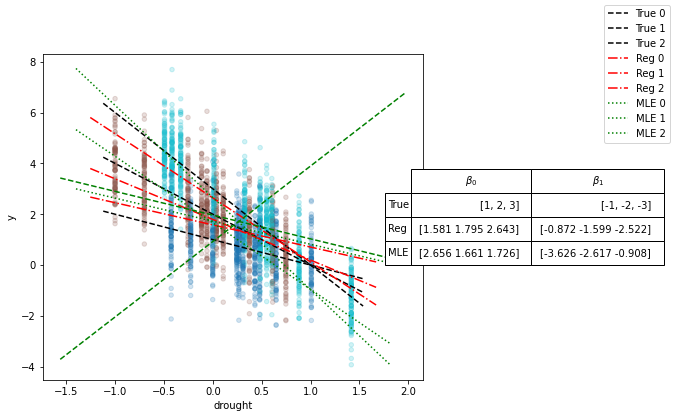

In [9]:
#     # Visualize Results
v = Visualizer(data = df, reg = res, mle = res_smle_s, true_beta0 = beta0, true_beta1=beta1)

fig, ax = plt.subplots(
    ncols=2, 
    figsize = (10,6), 
    gridspec_kw=dict(width_ratios=[3,1])
    )
v.plot(plot_reg=True, plot_mle = True, plot_true = True, ax=ax, fig=fig)

new_beta0_mle, new_beta1_mle, _ = get_mle_betas(res_smle, 2)

v._plot_line(ax=ax[0], beta0=new_beta0_mle, beta1=new_beta1_mle, labels ='New MLE', linestyle ='--', color='green')


In [14]:
beta0 = [1,2,3]
beta1 = [-1, -2,-3]


u = UberDatasetCreator(seed=1, regimes=3, drivers= 275)
df, wm = u.construct(y_sd = [1,1,1],
                drought_mean = [0,0,0],
                drought_cov = [1,1,1],
                beta0 = beta0,
                beta1 = beta1,
                y_name = 'y',
                weight = .8,
                # reg_ready=True
                )

classifier_cols = df.columns[df.columns.str.contains("misclass_regime_")].tolist()

drought_cols = df.columns[df.columns.str.contains("drought_")].tolist()   

mod = uber_regression(df, 'y', classifier_cols=classifier_cols, drought_cols=drought_cols)

p_mat_start = logit(np.diag(wm))

res = mod.fit()


In [15]:
us = SimplifiedUberMLE(data = df, 
            endog_col = 'y', 
            classifier_cols = classifier_cols,
            drought_cols=drought_cols)  

_, _, start_params = get_reg_effect(res)

start_params = np.append(start_params, np.full((1,u.regimes), 1)) # sigma
start_params = np.append(start_params, np.full(shape = (1,u.regimes-1), fill_value = logit(1/u.regimes))) # l_vec
start_params = np.append(start_params, p_mat_start)

res_smle_s = us.fit(start_params=start_params, method = 'bfgs')

print(res_smle_s.summary())

# %%
us = UberMLE(data = df, 
            endog_col = 'y', 
            classifier_cols = classifier_cols,
            drought_cols=drought_cols)  

_, _, start_params = get_reg_effect(res)

start_params = np.append(start_params, np.full((1,u.regimes), 1)) # sigma
start_params = np.append(start_params, np.full(shape = (1,u.regimes-1), fill_value = logit(1/u.regimes))) # l_vec
start_params = np.append(start_params, logit(wm[0:u.regimes-1,:]))

res_smle = us.fit(start_params=start_params, method = 'bfgs')

print(res_smle.summary())

Optimization terminated successfully.
         Current function value: 2.518256
         Iterations: 78
         Function evaluations: 79
         Gradient evaluations: 79
                          SimplifiedUberMLE Results                           
Dep. Variable:                      y   Log-Likelihood:                -6925.2
Model:              SimplifiedUberMLE   AIC:                         1.387e+04
Method:            Maximum Likelihood   BIC:                         1.394e+04
Date:                Thu, 03 Sep 2020                                         
Time:                        14:49:50                                         
No. Observations:                2750                                         
Df Residuals:                    2739                                         
Df Model:                          10                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

array([<AxesSubplot:xlabel='drought', ylabel='y'>, <AxesSubplot:>],
      dtype=object)

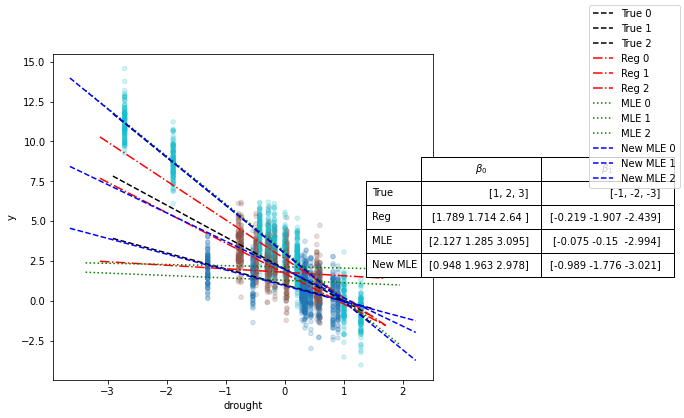

In [24]:
v = Visualizer(data = df, reg = res, mle = res_smle_s, true_beta0 = beta0, true_beta1=beta1)

fig, ax = plt.subplots(
    ncols=2, 
    figsize = (10,6), 
    gridspec_kw=dict(width_ratios=[3,1])
    )

new_beta0_mle, new_beta1_mle, _ = get_mle_betas(res_smle, 3)

v.plot(plot_reg=True, plot_mle = True, plot_true = True, ax=ax, fig=fig,other_beta0 = new_beta0_mle, other_beta1 = new_beta1_mle, other_title = 'New MLE')


In [25]:
beta0 = [1,2,3,4]
beta1 = [-1, -2,-3,-5]


u = UberDatasetCreator(seed=1, regimes=4, drivers= 275)
df, wm = u.construct(y_sd = [1,1,1,1],
                drought_mean = [0,0,0,0],
                drought_cov = [1,1,1,1],
                beta0 = beta0,
                beta1 = beta1,
                y_name = 'y',
                weight = .8,
                # reg_ready=True
                )

classifier_cols = df.columns[df.columns.str.contains("misclass_regime_")].tolist()

drought_cols = df.columns[df.columns.str.contains("drought_")].tolist()   

mod = uber_regression(df, 'y', classifier_cols=classifier_cols, drought_cols=drought_cols)

p_mat_start = logit(np.diag(wm))

res = mod.fit()


In [26]:
us = SimplifiedUberMLE(data = df, 
            endog_col = 'y', 
            classifier_cols = classifier_cols,
            drought_cols=drought_cols)  

_, _, start_params = get_reg_effect(res)

start_params = np.append(start_params, np.full((1,u.regimes), 1)) # sigma
start_params = np.append(start_params, np.full(shape = (1,u.regimes-1), fill_value = logit(1/u.regimes))) # l_vec
start_params = np.append(start_params, p_mat_start)

res_smle_s = us.fit(start_params=start_params, method = 'bfgs')

print(res_smle_s.summary())

# %%
us = UberMLE(data = df, 
            endog_col = 'y', 
            classifier_cols = classifier_cols,
            drought_cols=drought_cols)  

_, _, start_params = get_reg_effect(res)

start_params = np.append(start_params, np.full((1,u.regimes), 1)) # sigma
start_params = np.append(start_params, np.full(shape = (1,u.regimes-1), fill_value = logit(1/u.regimes))) # l_vec
start_params = np.append(start_params, logit(wm[0:u.regimes-1,:]))

res_smle = us.fit(start_params=start_params, method = 'bfgs')

print(res_smle.summary())

Optimization terminated successfully.
         Current function value: 2.691082
         Iterations: 106
         Function evaluations: 107
         Gradient evaluations: 107
                          SimplifiedUberMLE Results                           
Dep. Variable:                      y   Log-Likelihood:                -7400.5
Model:              SimplifiedUberMLE   AIC:                         1.483e+04
Method:            Maximum Likelihood   BIC:                         1.492e+04
Date:                Thu, 03 Sep 2020                                         
Time:                        15:03:34                                         
No. Observations:                2750                                         
Df Residuals:                    2735                                         
Df Model:                          14                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

array([<AxesSubplot:xlabel='drought', ylabel='y'>, <AxesSubplot:>],
      dtype=object)

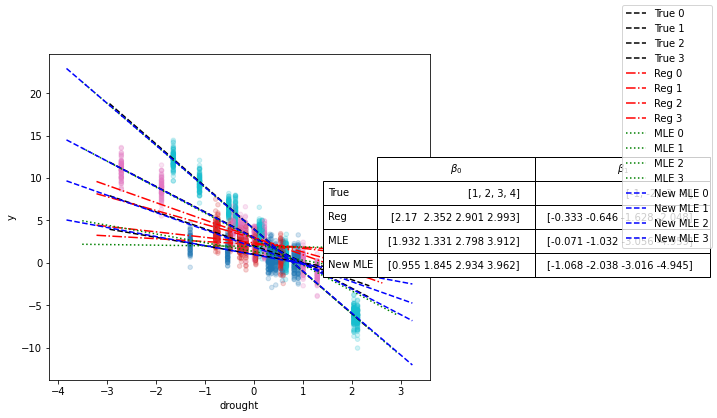

In [28]:
v = Visualizer(data = df, reg = res, mle = res_smle_s, true_beta0 = beta0, true_beta1=beta1)

fig, ax = plt.subplots(
    ncols=2, 
    figsize = (10,6), 
    gridspec_kw=dict(width_ratios=[3,1])
    )

new_beta0_mle, new_beta1_mle, _ = get_mle_betas(res_smle, 4)

v.plot(plot_reg=True, plot_mle = True, plot_true = True, ax=ax, fig=fig,other_beta0 = new_beta0_mle, other_beta1 = new_beta1_mle, other_title = 'New MLE')
